## Simulation of plane wave incident on dual microlens arrays (MLA's) for laser beam array generation.

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


# Setup the MLA geometry
We'll start by defining the geometry of the MLA's.
+ Prior to the objective there are two MLA's with the same parameters.
+ They are spaced by one focal length such that the second MLA is in the focal plane of the first.
+ Each lenslet has the same focal length as all the other lenslets. This is true for lenslets in both MLA's.

In [2]:
numLenslets = 21    # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize = 500   # microns
focalLength = 13700 # microns

wavelength  = 0.642 # microns

Now we'll establish a GridArray to represent the microlenses. Such an array is a coordinate system onto which the individual lenslets are mapped. The GridArray is primarily a convenience class because it manages all unit conversions when performing Fourier transforms.

The most important parameter here is the subgridSize. This is the number of discrete lattice sites into which a lenslet will be divided. The spatial sampling period for each lenslet will therefore be

$$\delta = \frac{p}{N_{\text{sub}}}$$

where $p$ is the MLA pitch in microns and $ N_{\text{sub}} $ is the subgrid size, i.e. the number of discrete lattice sites along one dimension of the MLA. For example, a MLA pitch of $p = 500 \, \mu m$ and a subgrid size of $N_{\text{sub}} = 51$ will result in a spatial sampling period of $\frac{500 \, \mu m}{51} \approx 9.8 \mu m$.

A good sampling rate should be smaller than the fastest oscillations in the amplitude and phase of the Fourier transform of the input field to avoid aliasing. Unfortunately, it is impossible to completely avoid aliasing when computing transforms of real apertures, which are not band-limited. We can however minimize their effects by choosing sampling periods as small as possible (or, equivalently, sampling frequencies as large as possible).

We also need to zero pad the input by a large enough amount to minimize rippling effects in the solutions. If we don't zero pad, the numerical Fourier transforms of the input fields are convolved with a sinc whose width is equal to the width of the field's spectrum. If this occurs, the sinc-based interpolation of the input field's spectrum results in additional artifacts.

The spatial sampling period used below is

$$ \delta = \frac{p}{N_{\text{sub}}} = \frac{500 \, \mu m}{50001} $$

In [3]:
print('Spatial sampling period: {0:.4f} microns'.format(500 / 50001.0))

Spatial sampling period: 0.0100 microns


In [4]:
subgridSize  = 50001                     # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
# zeroPad = N makes the computational grid N times larger than the MLA
grid = grids.GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1, zeroPad = 5)

# Define the input field
Next, we'll define an input laser beam that will impinge upon the first MLA. Because this is a 1D geometry, the input field \\( u \left( x \right) \\) is in units of \\( \frac{\text{Volts}}{\sqrt{\mu m}} \\). With \\( a \\) denoting the total width of the array (the variable `physicalSize` above), the total power input into the MLA's is

$$ P = \frac{\int_{-a/2}^{a/2} \left| u \left( x \right) \right|^2 dx}{Z_{0}} $$

which has units of \\( \frac{\text{Volts}^2}{\Omega} \\). \\( Z_0 \\) is the [impedance of free space](https://en.wikipedia.org/wiki/Impedance_of_free_space), \\( Z_0 \approx 376.73 \, \Omega \\).

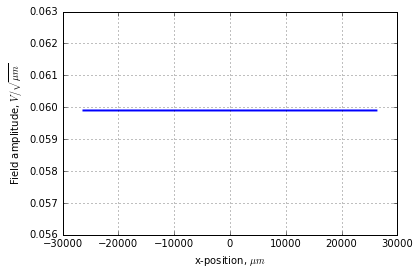

In [5]:
powerIn = 100 # mW
Z0      = 376.73 # Impedance of free space, Ohms

# Determine the field amplitude
fieldAmp = np.sqrt((powerIn / 1000) * Z0 / physicalSize) # Volts / sqrt(microns)

# Plane wave
uIn = lambda x: fieldAmp
uIn = np.vectorize(uIn)

# Plot the input field over the array
plt.plot(grid.px, uIn(grid.px), linewidth = 2)
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.grid(True)
plt.show()

# Find the field immediately after the second MLA
The field immediately *after* the second MLA is a summation of the Fourier transforms of all the fields sampled by each lenslet in the first array. Each transform is centered around the axis of its corresponding lenslet. Therefore, we have to compute a Fourier transform for each lenslet separately and then shift the origin of its coordinate axes onto the axis for the corresponding lenslet. Mathematically, the field immediately after the second MLA is

$$ u_{1}' \left( x' \right) = \sum_{m = -\frac{N - 1}{2}}^{\frac{N-1}{2}} \frac{1}{\sqrt{j \lambda f_{LA}}} \int_{-\infty}^{\infty} u \left( x \right) \text{rect} \left( \frac{x - mp}{p}\right) \exp \left[ - j \frac{2 \pi}{\lambda f_{LA}} \left( x - mp \right) \left( x' + mp \right) \right] dx$$

with \\(N \\) odd, \\( f_{LA} \\) representing the lenslet focal length, and \\( \text{rect} \left( x \right) \\) equal to one between \\(-1/2 \\) and \\(+ 1/2 \\) and zero elsewhere. The multiplication of the input field by the \\( \text{rect} \\) function models a single lenslet sampling a region of the field. The sampled field is then Fourier transformed by the integral with the Fourier transform centered on the center coordinates for the respective lenslet. The transformed fields are then summed over all \\( N \\) lenslets.

The reason that there is no quadratic phase curvature preceding the transforms is because the second MLA acts as a field lens, effectively canceling the quadratic phase terms. In doing so, we ignore regions of the diffracted field that leak onto neighboring lenslets because
1. they carry little energy relative to the center of the diffracted field, and
2. the tails of the diffracted fields contain aliasing artifacts anyway.

To compute this spatially-parallelized Fourier transform, we use SimMLA's fftSubgrid routine. It will return two lists of interpolated fields, one for the magnitude and one for the phase. We will then resample this field onto a new grid representing the coordinate axes immediately after the second MLA.

In [6]:
# Compute the interpolated fields
# Linear interpolation is used for speed
%time interpMag, interpPhase = simfft.fftSubgrid(uIn, grid)

CPU times: user 3min 3s, sys: 10.6 s, total: 3min 13s
Wall time: 3min 13s


Now that we have the interpolated fields, we'll define a new grid for sampling them. We'll give the grid the same physical extent as before, but we may choose to increase the spatial sampling rate slightly. We will also use the focal length of the objective because it will serve as the final Fourier transforming lens in the system.

*If we increase the sampling rate for the new grid, it won't necessarily fix any subsampling that occurred in the previous step. It will only provide better resolution at the possibly aliased results.*

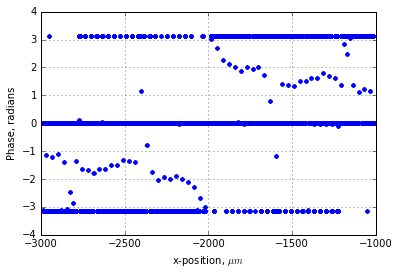

In [7]:
# Check that we've successfully computed the Fourier transform of a lenslet.
m = 6 # lenslet index, integers between [0, numLenslets - 1]
plt.plot(grid.px, np.angle(interpMag[m](grid.px) * np.exp(1j * interpPhase[m](grid.px))),'.')
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Phase, radians')
plt.xlim((-3000,-1000))
plt.grid(True)
plt.show()

In [8]:
%%time
fObj        = 3300 # microns
newGridSize = subgridSize * numLenslets # microns

# Upsample grid by an odd factor to reduce rippling
newGrid = grids.Grid(5*newGridSize, 5*physicalSize, wavelength, fObj, dim = 1)
field   = np.zeros(newGrid.gridSize)

# For each interpolated magnitude and phase corresponding to a lenslet
# 1) Compute the full complex field
# 2) Sum it with the other complex fields
for currMag, currPhase in zip(interpMag, interpPhase):
    fieldMag   = currMag(newGrid.px)
    fieldPhase = currPhase(newGrid.px)
    
    currField = fieldMag * np.exp(1j * fieldPhase)
    field     = field + currField

CPU times: user 18.8 s, sys: 4.26 s, total: 23 s
Wall time: 23 s


Let's plot the field amplitude and phase just immediately after the second MLA. Note that there are 21 focused spots corresponding the focus of each microlens array.

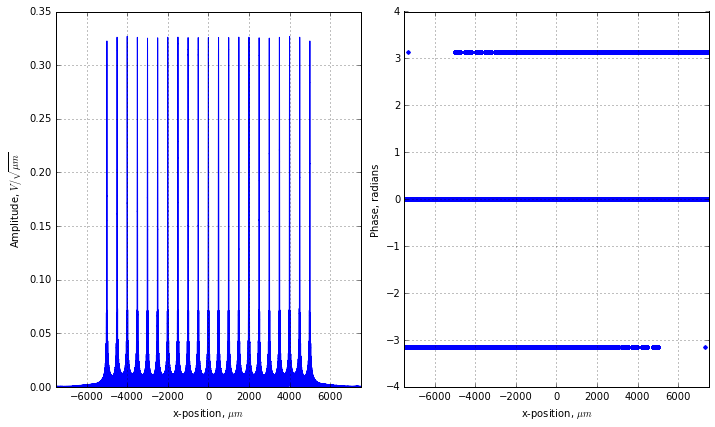

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows = 1,
                               ncols = 2,
                               sharex = True,
                               sharey = False,
                               figsize = (10,6))

ax0.plot(newGrid.px, np.abs(field))
ax0.set_xlim((-7500, 7500))
ax0.set_xlabel(r'x-position, $\mu m$')
ax0.set_ylabel(r'Amplitude, $V / \sqrt{\mu m}$')
ax0.grid()

ax1.plot(newGrid.px, np.angle(field), '.')
ax1.set_xlabel(r'x-position, $\mu m$')
ax1.set_ylabel('Phase, radians')
ax1.grid()

plt.tight_layout()
plt.show()

We can also check that energy has been conserved, at least to within numerical round off errors. The power delivered by the diffracted field \\( u_{1}' \left( x' \right) \\) just past the second MLA is

$$ P_{1}' = \frac{\int_{-\infty}^{\infty} \left| u \left( x' \right) \right|^2 dx'}{Z_{0}} $$

Note that the diffracted field carries a prefactor of \\( \frac{1}{\sqrt{\lambda f_{LA}}} \\) which is taken care of by SimMLA.

In [10]:
from scipy.integrate import simps
# Factor of 1000 converts from Watts to milliWatts
power1Prime = simps(np.abs(field)**2, newGrid.px) / Z0 * 1000 

print('Input power is: {0:.4f} mW'.format(powerIn))
print('Diffracted power is: {0:.4f} mW'.format(power1Prime))

Input power is: 100.0000 mW
Diffracted power is: 101.9432 mW


# Find the field on the sample
## Compute the field in the objective's back focal plane
The final step is to compute the field formed in the sample plane and coming from the second MLA. This problem involves two smaller steps:
1. Propagating the field to the objective's back focal plane and setting field components outside the objective's aperture to zero
2. Fourier transforming this field to get the field distribution on the sample.

The second step follows from the fact that we are using infinity-corrected objectives in which the sample plane and front focal plane are coplanar. This allows for the Fourier transform relation between the BFP and the sample plane: the field distribution in the front focal plane of a lens is the exact Fourier transform of the field in the lens's rear focal plane.

In [11]:
propDistance = 200000 # Approximate distance between second MLA and objective's back focal plane, microns
u2 = simfft.fftPropagate(field, newGrid, 20000)

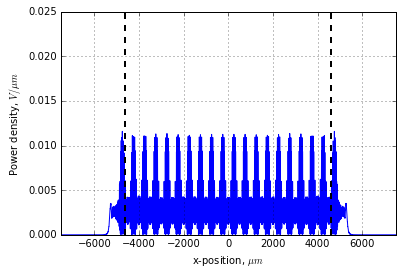

In [12]:
bfpDiam = 2 * 1.4 * 3300 # BFP diameter, 2 * NA * f_OBJ
yMax = 0.025

# Plot the field in the objective's back focal plane without the aperture
plt.plot(newGrid.px, np.abs(u2)**2)
plt.plot([-bfpDiam / 2, -bfpDiam / 2], [0, yMax], '--k', linewidth = 2, label = 'Back aperture')
plt.plot([bfpDiam / 2, bfpDiam / 2],   [0, yMax], '--k', linewidth = 2)
plt.xlim((-7500, 7500))
plt.ylim((0, yMax))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Power density, $V / \mu m$')
plt.grid(True)
plt.show()

In [13]:
# Is power still conserved?
# No scaling factor is necessary because the angular spectrum was only shifted in phase.
powerBFPIn = simps(np.abs(u2)**2, newGrid.px) / Z0 * 1000
print('Power before the aperture in the BFP: {0:.4f} mW'.format(powerBFPIn))

Power before the aperture in the BFP: 101.9408 mW


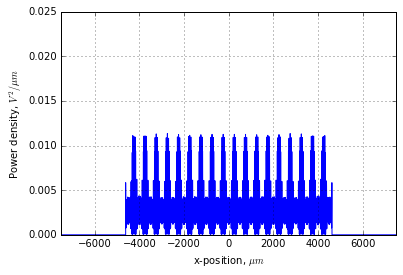

In [14]:
# Set field components outside the back aperture to zero
u2Prime = u2.copy()
u2Prime[np.logical_or(newGrid.px < -bfpDiam / 2, newGrid.px > bfpDiam / 2)] = 0.0

# Plot the field in the objective's back focal plane without the aperture
plt.plot(newGrid.px, np.abs(u2Prime)**2)
plt.xlim((-7500, 7500))
plt.ylim((0, yMax))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Power density, $V^2 / \mu m$')
plt.grid(True)
plt.show()

In [15]:
# How much power is lost due to truncation?
powerBFPOut = simps(np.abs(u2Prime)**2, newGrid.px) / Z0 * 1000
print('Power after the aperture in the BFP: {0:.4f} mW'.format(powerBFPOut))
print('Approximately {0:.4f} mW of power is lost.'.format(powerBFPIn - powerBFPOut))

Power after the aperture in the BFP: 89.1570 mW
Approximately 12.7839 mW of power is lost.


## Compute the field on the sample

In [16]:
# Sample plane irradiance including limiting aperture in the BFP
scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
F             = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(u2Prime)))

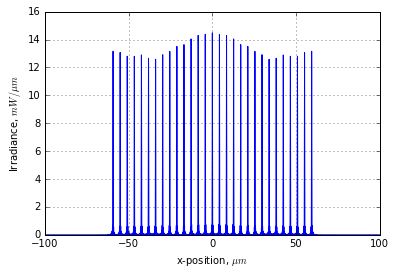

Power delivered to sample: 89.1569 mW


In [17]:
filename = 'planewave_subgridsize{0:d}.png'.format(subgridSize)

plt.plot(newGrid.pX, np.abs(F)**2 / Z0 * 1000)
plt.xlim((-100, 100))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Irradiance, $mW / \mu m$')
plt.grid(True)
#plt.savefig(filename)
plt.show()

powerSample = simps(np.abs(F)**2, newGrid.pX) / Z0 * 1000
print('Power delivered to sample: {0:.4f} mW'.format(powerSample))

The field is roughly uniform, but it's not what we would have expected from the literature. Does the clipping due to the back aperture affect the uniformity?

In [18]:
# Sample plane irradiance including limiting aperture in the BFP
scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
F_unclipped   = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(u2)))

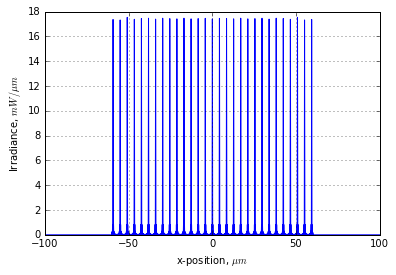

Power delivered to sample: 89.1569 mW


In [19]:
plt.plot(newGrid.pX, np.abs(F_unclipped)**2 / Z0 * 1000)
plt.xlim((-100, 100))
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Irradiance, $mW / \mu m$')
plt.grid(True)
plt.show()

powerSample = simps(np.abs(F)**2, newGrid.pX) / Z0 * 1000
print('Power delivered to sample: {0:.4f} mW'.format(powerSample))

This is much more like what is predicted in the literature. From this we can conclude that we have accurately constructed a simulation for the dual MLA's that works with our microscope. Interestingly, we found that clipping due to the objective's rear aperture can reduce the uniformity of the illumination.